In [361]:
%load_ext autoreload
%autoreload 2

from wb_api_wraper import *

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from IPython.display import display, HTML

import matplotlib.pyplot as plt 
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [362]:
#Pandas display options
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.width', 200)
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 20)

In [363]:
#Options for plots
font = {'family' : 'serif',
    'weight' : 'normal',
    'size'   : 12}

plt.rc('font', **font)
plt.rcParams["legend.fancybox"]=True
plt.rcParams["savefig.dpi"]=90

plot_options = dict(alpha=0.5,clip_on=False)

def format_fig(ax):
    ax.set_xlim(0)
    ax.set_ylim(0)

In [364]:
#Searching the WB API database

search_wb("GDP");
search_wb("emissions");

#Data

In [365]:
gni = True #use GDP per capita if if false

In [366]:
all_ghg = True  #use only CO2 if false, all GHG if true

###Pop and gdp

In [367]:
gdp_pc_ppp  = get_wb("NY.GNP.PCAP.PP.CD") if gni else get_wb("NY.GDP.PCAP.PP.CD")#GDP per capita, PPP (constant 2011 international $)
gdp = get_wb("NY.GDP.MKTP.PP.KD")#GGDP, PPP (constant 2011 international $)
pop = get_wb("SP.POP.TOTL") #population

In [368]:
#(pop*gdp_pc_ppp)/gdp #sanity check: pop, gdp and gdp_pc are consistent, notably in recent years

###Emissions

In [369]:
#emis_intens = get_wb_mrv("EN.ATM.CO2E.KD.GD","emis_intens") /1000 #CO2 emissions (data in kg per 2005 US$ of GDP), converted in tons per ...
emis_intens = get_wb("EN.ATM.CO2E.PP.GD.KD")/1000 #CO2 emissions in tons, from  #CO2 emissions (kg per 2011 PPP $ of GDP)
emis_tot = get_wb("EN.ATM.CO2E.KT")*1000 #emissions in tons
#Both series end in 2011

if all_ghg:
    other_ghg_tot = (get_wb("EN.ATM.METH.KT.CE")  #total methane
                      +get_wb("EN.ATM.NOXE.KT.CE")  #total nitrous o
                      +get_wb("EN.ATM.GHGO.KT.CE") #total other
                      )*1000 #emissions in tons


    for c in range(2000,2011):
        if str(c) not in other_ghg_tot.columns:
            other_ghg_tot[str(c)]=np.nan


    from scipy.interpolate import interp1d

    other_ghg_tot=other_ghg_tot.sort_index(axis=1).interpolate(axis=1)
    other_ghg_tot["2011"]=2*other_ghg_tot["2010"]-other_ghg_tot["2009"]

    emis_tot=(emis_tot+other_ghg_tot).fillna(emis_tot)
    
emis_intes = emis_tot /gdp 

In [370]:
other_ghg_tot["2011"].sum()

66038056000.0

In [371]:
#(emis_intens*gdp/emis_tot) #sanity check: these amtch exactly (intens must be computed this way)

###Dataframe

In [372]:
#Income gorups for countries and HIPC status
groups = pd.read_csv("counry_income_groups.csv",header =4,index_col=2).replace({"ROM":"ROU","ZAR":"COD"})  #they used old iso3 country for Zair (Congo) and Romania
groups.dropna(axis=0,how="all",inplace=True);

In [373]:
df=pd.DataFrame()
df["emis_intens"]=emis_intens.stack()
df["gdp_pc"] = gdp_pc_ppp.stack()
df["pop"] = pop.stack()
df["emis_tot"] = emis_tot.stack()

emis_pc = emis_tot.stack()/pop.stack()
df["emis_pc"]= emis_pc

df= df.ix[groups.index.values] #keeps only actula countries (no macro regions or groups of countries)

data_all = df.reset_index()

#emission intensity last year
emis_intens_peryear=data_all.set_index(["country","year"]).emis_intens.unstack()
emis_intens_last_year =emis_intens_peryear[0:-1]
emis_intens_last_year.columns=emis_intens_last_year.columns.map(lambda x: str(1+eval(x)))
emis_intens_last_year.columns.name="year"
emis_intens_last_year.stack().reset_index()

data_all=pd.merge(data_all,emis_intens_last_year.stack().reset_index(),on=["country","year"],how="outer").dropna().rename(columns={0:"emis_intens_last_year"})


#income bins
bins = [0]+ data_all.gdp_pc.quantile([.2,.4,.6,.8,1]).tolist()
bins

x=pd.cut(data_all.gdp_pc,bins);
x.name="inc_bins"

data_all = pd.concat([data_all,x],axis=1)


#dummy for 2011 to center the rpediciton there
data_all["dummy2011"]=(data_all["year"]=="2011")+0


In [374]:
#Current emissions
emis_ref = data_all.query("year=='2011'").emis_tot.sum()
print("Global CO2 emissions in the sample: {emis:0.0f} GtCO2".format(emis=emis_ref*1e-9)+"eq" if all_ghg else "")

Global CO2 emissions in the sample: 43 GtCO2eq


In [375]:
emissions_2030_RCP = 7*44/12
32/emissions_2030_RCP

1.2467532467532467

In [376]:
data2011["pop"].sum()

6664202323.0

###Emissions in LICs today

In [377]:
#What ending povety means
target_gdp_pc = 3500

In [378]:
data2011= data_all.query("year=='2011'").copy()
LICs = data2011.ix[data2011.gdp_pc<target_gdp_pc].index
data2011.ix[LICs].emis_tot.sum()/emis_ref*100

2.6087771017573114

In [379]:
print(data2011.ix[LICs].country.tolist())
len(LICs)

['Afghanistan', 'Bangladesh', 'Benin', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo, Dem. Rep.', 'Eritrea', 'Ethiopia', 'Gambia, The', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Haiti', 'Kenya', 'Kiribati', 'Kyrgyz Republic', 'Lesotho', 'Liberia', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mozambique', 'Nepal', 'Niger', 'Papua New Guinea', 'Rwanda', 'Senegal', 'Sierra Leone', 'Solomon Islands', 'Sudan', 'Tajikistan', 'Tanzania', 'Togo', 'Uganda', 'Vanuatu', 'Yemen, Rep.', 'Zambia']


43

#Simulations

In [380]:
gdp_proj = pd.read_csv("gdp_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP4'")["2030"]


In [381]:
pop_proj = pd.read_csv("population_ssp.csv", index_col="country", dtype={"scenario":str}).query("scenario=='SSP4'")["2030"]*1e6
pop_proj = pop_proj.sort_index().copy()

In [382]:


def project_emissions(formula, data):
    print("\n"+formula)
    
    data2011= data.query("year=='2011'").copy()
    LICs = data2011.ix[data2011.gdp_pc.clip(lower=target_gdp_pc)==target_gdp_pc].index
    
    mod = smf.ols(formula, data).fit()
    mod_weighted = smf.wls(formula, data, weights = data["pop"]).fit()

    
    print("\n========= Predicted 2011")
    simulation = data2011
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    print("Error in 2011: {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=emis_tot.sum()/emis_ref-1,
            y=emis_tot_weighted.sum()/emis_ref-1)
         )
    
    e_ref = emis_tot
    e_w_ref = emis_tot_weighted
    
    
    def report(emis_tot,emis_tot_weighted):
        print("Emissions increased by {x:0.1%} (unweighted)  or {y:0.1%} (weighted)".format(
            x=(emis_tot).sum()/emis_ref,
            y=(emis_tot_weighted).sum()/emis_ref)
         )
    
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print("\n========= Liting Income")
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc), inc_bins = pd.cut(data2011.gdp_pc,bins))
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print('\n==========Liting Income and population')
    simulation = data2011.assign(gdp_pc = data.gdp_pc.clip(lower=target_gdp_pc),inc_bins = pd.cut(data2011.gdp_pc,bins) )
    simulation.ix[LICs,"pop"] = pop_proj.ix[data.ix[LICs].country].values
    
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    
    print('\n==========new POPULATION, old income')
    simulation = data2011
    simulation.ix[LICs,"pop"] = pop_proj.ix[data.ix[LICs].country].values
    emis_tot =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]

    emis_tot_weighted =mod_weighted.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    report(emis_tot-e_ref,emis_tot_weighted-e_w_ref)
    #simulation["emis_tot_weighted"] =mod.predict(simulation)*simulation["gdp_pc"]*simulation["pop"]
    
    #simulation["emis_intens_pred"]
    #simulation["emis_pc"] = simulation["emis_intens_pred"]
    #simulation["emis_tot"] = simulation["emis_pc"]

    #print("\nEmissions increased by {x:0.1%}[{cil:0.1%}, {ciu:0.1%}]".format(
    #        x  =simulation.emis_tot.sum()/emis_ref-1,
    #        ciu=(simulation.emis_tot*iv_u/simulation["emis_intens_pred"]).sum()/emis_ref-1,
    #        cil=(simulation.emis_tot*iv_l/simulation["emis_intens_pred"]).sum()/emis_ref-1
    #     ))
    

    
    return mod,mod_weighted
    

###Constant emission intensity using 2011 data

In [383]:
formula="emis_intens ~ country - 1"

In [384]:
mod, mod_w= project_emissions(formula, data_all.query("year=='2011'").copy())
mod.summary();


emis_intens ~ country - 1

========= Predicted 2011
Error in 2011: -26.5% (unweighted)  or -26.5% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)

==========Liting Income and population
Emissions increased by 0.8% (unweighted)  or 0.8% (weighted)

==========new POPULATION, old income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)


In [385]:
mod, mod_w= project_emissions(formula, data_all)


emis_intens ~ country - 1

========= Predicted 2011
Error in 2011: -19.5% (unweighted)  or -19.6% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)

==========Liting Income and population
Emissions increased by 0.7% (unweighted)  or 0.7% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


###Country fix effect and gdpglobal effect

everything signigicant

In [386]:
formula="emis_intens ~ gdp_pc+country- 1 "

mod, mod_w  = project_emissions(formula, data_all)
#foo.summary()
mod.summary();


emis_intens ~ gdp_pc+country- 1 

========= Predicted 2011
Error in 2011: -23.8% (unweighted)  or -27.5% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.3% (unweighted)  or 0.2% (weighted)

==========Liting Income and population
Emissions increased by 0.6% (unweighted)  or 0.6% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


In [387]:
formula="emis_intens ~ gdp_pc+country + emis_intens_last_year- 1"

mod, mod_w  = project_emissions(formula, data_all)
#foo.summary()
mod.summary()


emis_intens ~ gdp_pc+country + emis_intens_last_year- 1

========= Predicted 2011
Error in 2011: -26.4% (unweighted)  or -27.2% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.3% (unweighted)  or 0.3% (weighted)

==========Liting Income and population
Emissions increased by 0.7% (unweighted)  or 0.7% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            emis_intens   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     494.2
Date:                Tue, 11 Aug 2015   Prob (F-statistic):               0.00
Time:                        19:44:37   Log-Likelihood:                 17527.
No. Observations:                1945   AIC:                        -3.469e+04
Df Residuals:                    1761   BIC:                        -3.366e+04
Df Model:                         183                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
country[Afghanistan]                     4.228e-05   1.04e-05      4.057      0.000      2.18e-05  6.27e-05
country[Albania]                          4.68e-05   9.95e-06      4.701      0.000      2.73e-05  6.63e-05
country[Algeria]                         6.404e-05   1.05e-05      6.118      0.000      4.35e-05  8.46e-05
country[Angola]                          5.208e-05   9.96e-06      5.226      0.000      3.25e-05  7.16e-05
country[Antigua and Barbuda]             7.785e-05    1.1e-05      7.050      0.000      5.62e-05  9.95e-05
country[Armenia]                         5.133e-05   1.03e-05      4.995      0.000      3.12e-05  7.15e-05
country[Australia]                          0.0001   1.41e-05      8.789      0.000      9.65e-05     0.000
country[Austria]                         8.325e-05    1.3e-05      6.407      0.000      5.78e-05     0.000
country[Azerbaijan]                      6.032e-05    1.2e-05      5.020      0.000      3.68e-05  8.39e-05
country[Bahamas, The]                    6.825e-05   1.11e-05      6.135      0.000      4.64e-05  9.01e-05
country[Bahrain]                            0.0001   1.49e-05      8.729      0.000         0.000     0.000
country[Bangladesh]                       3.45e-05   9.61e-06      3.591      0.000      1.57e-05  5.33e-05
country[Barbados]                        9.077e-05   1.11e-05      8.160      0.000       6.9e-05     0.000
country[Belarus]                            0.0001   1.28e-05      7.947      0.000      7.66e-05     0.000
country[Belgium]                         8.832e-05   1.31e-05      6.743      0.000      6.26e-05     0.000
country[Belize]                          3.894e-05   1.01e-05      3.854      0.000      1.91e-05  5.88e-05
country[Benin]                           6.659e-05   9.95e-06      6.690      0.000      4.71e-05  8.61e-05
country[Bermuda]                            0.0001   2.08e-05      4.909      0.000      6.14e-05     0.000
country[Bhutan]                           2.57e-05   9.64e-06      2.666      0.008      6.79e-06  4.46e-05
country[Bolivia]                         6.668e-05   1.03e-05      6.466      0.000      4.65e-05  8.69e-05
country[Bosnia and Herzegovina]             0.0001   1.25e-05     10.711      0.000         0.000     0.000
country[Botswana]                         5.01e-05   1.02e-05      4.902      0.000      3.01e-05  7.01e-05
country[Brazil]                          4.358e-05      1e-05      4.344      0.000      2.39e-05  6.33e-05
country[Brunei Darussalam]                  0.0001   1.84e-05      7.096      0.000      9.43e-05     0.000
country[Bulgaria]                           0.0001   1.23e-05      8.594      0.000      8.13e-05     0.000
country[Burkina Faso]                    1.749e-05   9.43e-

###Square income

In [388]:
formula="emis_intens ~ gdp_pc + I(gdp_pc**2)+ country  - 1"
mod, mod_w  = project_emissions(formula, data_all)
mod.summary()


emis_intens ~ gdp_pc + I(gdp_pc**2)+ country  - 1

========= Predicted 2011
Error in 2011: -26.0% (unweighted)  or -26.9% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)

==========Liting Income and population
Emissions increased by 0.5% (unweighted)  or 0.5% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            emis_intens   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     177.5
Date:                Tue, 11 Aug 2015   Prob (F-statistic):               0.00
Time:                        19:44:38   Log-Likelihood:                 16563.
No. Observations:                1945   AIC:                        -3.276e+04
Df Residuals:                    1761   BIC:                        -3.173e+04
Df Model:                         183                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
country[Afghanistan]                        0.0001    1.7e-05      7.029      0.000      8.62e-05     0.000
country[Albania]                            0.0003   1.61e-05     16.359      0.000         0.000     0.000
country[Algeria]                            0.0004   1.67e-05     21.542      0.000         0.000     0.000
country[Angola]                             0.0003   1.56e-05     17.061      0.000         0.000     0.000
country[Antigua and Barbuda]                0.0004   1.89e-05     22.475      0.000         0.000     0.000
country[Armenia]                            0.0003   1.58e-05     20.117      0.000         0.000     0.000
country[Australia]                          0.0007   2.29e-05     31.634      0.000         0.001     0.001
country[Austria]                            0.0005   2.38e-05     21.443      0.000         0.000     0.001
country[Azerbaijan]                         0.0005   1.64e-05     32.219      0.000         0.000     0.001
country[Bahamas, The]                       0.0004   1.98e-05     20.444      0.000         0.000     0.000
country[Bahrain]                            0.0008   2.38e-05     32.874      0.000         0.001     0.001
country[Bangladesh]                         0.0002   1.54e-05     10.931      0.000         0.000     0.000
country[Barbados]                           0.0005   1.74e-05     26.951      0.000         0.000     0.001
country[Belarus]                            0.0006   1.68e-05     38.226      0.000         0.001     0.001
country[Belgium]                            0.0006   2.34e-05     23.637      0.000         0.001     0.001
country[Belize]                             0.0003    1.6e-05     17.586      0.000         0.000     0.000
country[Benin]                              0.0003   1.54e-05     17.440      0.000         0.000     0.000
country[Bermuda]                            0.0006   3.43e-05     16.138      0.000         0.000     0.001
country[Bhutan]                             0.0002   1.57e-05     11.101      0.000         0.000     0.000
country[Bolivia]                            0.0003   1.56e-05     21.393      0.000         0.000     0.000
country[Bosnia and Herzegovina]             0.0006   1.61e-05     39.732      0.000         0.001     0.001
country[Botswana]                           0.0003   1.67e-05     18.464      0.000         0.000     0.000
country[Brazil]                             0.0003   1.69e-05     15.610      0.000         0.000     0.000
country[Brunei Darussalam]                  0.0007   3.01e-05     21.815      0.000         0.001     0.001
country[Bulgaria]                           0.0006   1.69e-05     35.561      0.000         0.001     0.001
country[Burkina Faso]                    9.024e-05   1.54e-

In [389]:
formula="emis_intens ~ gdp_pc + I(gdp_pc**2)+ country  - 1"
mod, mod_w  = project_emissions(formula, data_all)
mod.summary()


emis_intens ~ gdp_pc + I(gdp_pc**2)+ country  - 1

========= Predicted 2011
Error in 2011: -26.0% (unweighted)  or -26.9% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)

==========Liting Income and population
Emissions increased by 0.5% (unweighted)  or 0.5% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            emis_intens   R-squared:                       0.949
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     177.5
Date:                Tue, 11 Aug 2015   Prob (F-statistic):               0.00
Time:                        19:44:39   Log-Likelihood:                 16563.
No. Observations:                1945   AIC:                        -3.276e+04
Df Residuals:                    1761   BIC:                        -3.173e+04
Df Model:                         183                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
country[Afghanistan]                        0.0001    1.7e-05      7.029      0.000      8.62e-05     0.000
country[Albania]                            0.0003   1.61e-05     16.359      0.000         0.000     0.000
country[Algeria]                            0.0004   1.67e-05     21.542      0.000         0.000     0.000
country[Angola]                             0.0003   1.56e-05     17.061      0.000         0.000     0.000
country[Antigua and Barbuda]                0.0004   1.89e-05     22.475      0.000         0.000     0.000
country[Armenia]                            0.0003   1.58e-05     20.117      0.000         0.000     0.000
country[Australia]                          0.0007   2.29e-05     31.634      0.000         0.001     0.001
country[Austria]                            0.0005   2.38e-05     21.443      0.000         0.000     0.001
country[Azerbaijan]                         0.0005   1.64e-05     32.219      0.000         0.000     0.001
country[Bahamas, The]                       0.0004   1.98e-05     20.444      0.000         0.000     0.000
country[Bahrain]                            0.0008   2.38e-05     32.874      0.000         0.001     0.001
country[Bangladesh]                         0.0002   1.54e-05     10.931      0.000         0.000     0.000
country[Barbados]                           0.0005   1.74e-05     26.951      0.000         0.000     0.001
country[Belarus]                            0.0006   1.68e-05     38.226      0.000         0.001     0.001
country[Belgium]                            0.0006   2.34e-05     23.637      0.000         0.001     0.001
country[Belize]                             0.0003    1.6e-05     17.586      0.000         0.000     0.000
country[Benin]                              0.0003   1.54e-05     17.440      0.000         0.000     0.000
country[Bermuda]                            0.0006   3.43e-05     16.138      0.000         0.000     0.001
country[Bhutan]                             0.0002   1.57e-05     11.101      0.000         0.000     0.000
country[Bolivia]                            0.0003   1.56e-05     21.393      0.000         0.000     0.000
country[Bosnia and Herzegovina]             0.0006   1.61e-05     39.732      0.000         0.001     0.001
country[Botswana]                           0.0003   1.67e-05     18.464      0.000         0.000     0.000
country[Brazil]                             0.0003   1.69e-05     15.610      0.000         0.000     0.000
country[Brunei Darussalam]                  0.0007   3.01e-05     21.815      0.000         0.001     0.001
country[Bulgaria]                           0.0006   1.69e-05     35.561      0.000         0.001     0.001
country[Burkina Faso]                    9.024e-05   1.54e-

###income bins

In [390]:
formula="emis_intens ~ gdp_pc:inc_bins+country - 1"
mod, mod_w  = project_emissions(formula, data_all)

mod.summary()


emis_intens ~ gdp_pc:inc_bins+country - 1

========= Predicted 2011
Error in 2011: -24.3% (unweighted)  or -27.0% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.6% (unweighted)  or 0.4% (weighted)

==========Liting Income and population
Emissions increased by 1.1% (unweighted)  or 0.9% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            emis_intens   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     171.8
Date:                Tue, 11 Aug 2015   Prob (F-statistic):               0.00
Time:                        19:44:39   Log-Likelihood:                 16550.
No. Observations:                1945   AIC:                        -3.273e+04
Df Residuals:                    1758   BIC:                        -3.168e+04
Df Model:                         186                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------------
country[Afghanistan]                     7.515e-05   1.82e-05      4.129      0.000      3.94e-05     0.000
country[Albania]                            0.0002   1.71e-05     12.240      0.000         0.000     0.000
country[Algeria]                            0.0003    1.7e-05     18.166      0.000         0.000     0.000
country[Angola]                             0.0002   1.65e-05     13.635      0.000         0.000     0.000
country[Antigua and Barbuda]                0.0004   1.83e-05     19.520      0.000         0.000     0.000
country[Armenia]                            0.0003   1.66e-05     16.466      0.000         0.000     0.000
country[Australia]                          0.0006   1.92e-05     30.288      0.000         0.001     0.001
country[Austria]                            0.0004   1.99e-05     18.066      0.000         0.000     0.000
country[Azerbaijan]                         0.0005   1.68e-05     28.061      0.000         0.000     0.001
country[Bahamas, The]                       0.0003   1.93e-05     17.198      0.000         0.000     0.000
country[Bahrain]                            0.0006   1.99e-05     31.764      0.000         0.001     0.001
country[Bangladesh]                         0.0001   1.68e-05      6.998      0.000      8.45e-05     0.000
country[Barbados]                           0.0004   1.69e-05     24.584      0.000         0.000     0.000
country[Belarus]                            0.0006   1.68e-05     35.208      0.000         0.001     0.001
country[Belgium]                            0.0004   1.96e-05     20.722      0.000         0.000     0.000
country[Belize]                             0.0002   1.67e-05     14.193      0.000         0.000     0.000
country[Benin]                              0.0002   1.71e-05     12.688      0.000         0.000     0.000
country[Bermuda]                            0.0004   3.34e-05     12.701      0.000         0.000     0.000
country[Bhutan]                             0.0001    1.7e-05      7.130      0.000       8.8e-05     0.000
country[Bolivia]                            0.0003   1.73e-05     16.064      0.000         0.000     0.000
country[Bosnia and Herzegovina]             0.0006   1.71e-05     34.137      0.000         0.001     0.001
country[Botswana]                           0.0003   1.69e-05     15.233      0.000         0.000     0.000
country[Brazil]                             0.0002   1.71e-05     12.374      0.000         0.000     0.000
country[Brunei Darussalam]                  0.0005   2.84e-05     18.149      0.000         0.000     0.001
country[Bulgaria]                           0.0005   1.69e-05     32.398      0.000         0.001     0.001
country[Burkina Faso]                    4.923e-05   1.65e-

###Country fix effect, year fix effect, and gdpglobal effect

year fixed effect non significant

In [391]:
formula="emis_intens ~ gdp_pc+country+year- 1"
m,mw=project_emissions(formula, data_all)
m.summary();


emis_intens ~ gdp_pc+country+year- 1

========= Predicted 2011
Error in 2011: -24.1% (unweighted)  or -27.6% (weighted)
Emissions increased by 0.0% (unweighted)  or 0.0% (weighted)

========= Liting Income
Emissions increased by 0.3% (unweighted)  or 0.2% (weighted)

==========Liting Income and population
Emissions increased by 0.6% (unweighted)  or 0.5% (weighted)

==========new POPULATION, old income
Emissions increased by 0.2% (unweighted)  or 0.2% (weighted)


###Plots

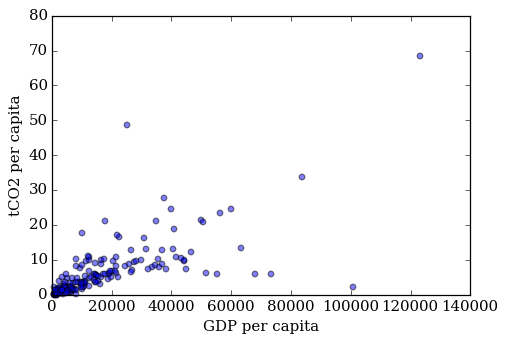

In [392]:
fig, ax = plt.subplots(1,1)
ax.scatter(data2011.gdp_pc,data2011.emis_pc,**plot_options)
ax.set_xlabel('GDP per capita')
ax.set_ylabel('tCO2 per capita')
format_fig(ax)